# **Tutorial 1: The Socioeconomic Origins of the Climate Emergency**

**Week 2, Day 3: IPCC Socio-economic Basis**

**Content creators:** Maximilian Puelma Touzel

**Content reviewers:** Peter Ohue, Derick Temfack, Zahra Khodakaramimaghsoud, Peizhen Yang, Younkap Nina DuplexLaura Paccini, Sloane Garelick, Abigail Bodner, Manisha Sinha, Agustina Pesce, Dionessa Biton, Cheng Zhang, Jenna Pearson, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**
In this tutorial, you will learn about the relationship between climate and socioeconomic models, and their role in guiding our responses to climate change. This tutorial will provide insights into the pressing issues of resource scarcity, population dynamics, and the potential impacts of unchecked resource extraction.

In this tutorial you will explore the Integrated Assessment Modelling (IAM) used in IPCC projections, and the influence of shared socio-economic pathways on these projections. You will also utilise the `World3` model,  a tool developed in the 1970s to analyze potential economic and population scenarios, to learn about nonlinear, coupled dynamics of various aggregated world system variables and how this model can be adapted to understand modern day climate challenges.

# **Setup**



In [1]:
# !pip install pyworld3

In [1]:
# imports
from IPython.display import Math
from IPython.display import display, HTML, Image
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
import pooch
import urllib
from pyworld3 import World3
from pyworld3.utils import plot_world_variables

In [2]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

sns.set_style("ticks", {'axes.grid': False})
%matplotlib inline
display(HTML("<style>.container { width:100% !important; }</style>"))
params = {'lines.linewidth': '3'}
plt.rcParams.update(params)

In [5]:
# @title Helper functions

def get_IPCC_data(var_name, path):
    IAMdf = pd.read_excel(path)
    IAMdf.drop(IAMdf.tail(2).index,inplace = True)  # excel file has 2 trailing rows of notes
    IAMdf.drop(['Model','Region','Variable','Unit','Notes'],axis=1,inplace =True) #remove columns we won't need

    # The data is in wideform (years are columns).
    # Longform (year of each datum as a column) is more convenient.
    # To collapse it to longform we'll use the `pd.wide_to_long` method that requires the following reformatting
    IAMdf.rename(columns=dict(zip(IAMdf.columns[1:],[var_name+str(y) for y in IAMdf.columns[1:]])),inplace=True) #add 'pop' to the year columns to tell the method which columns to map
    IAMdf.index = IAMdf.index.set_names(['id']) #name index
    IAMdf=IAMdf.reset_index() #make index a column
    IAMdf=pd.wide_to_long(IAMdf, [var_name], i='id', j="year")

    IAMdf=IAMdf.reset_index().drop('id',axis=1) #do some post mapping renaming
    IAMdf.year=IAMdf.year.apply(int) #turn year data from string to int
    if var_name=='pop':
        IAMdf[var_name]=1e6*IAMdf[var_name] #pop is in millions
    elif var_name=='CO2':
        IAMdf[var_name]=1e6*IAMdf[var_name] #CO2 is in Mt CO2/yr
    elif var_name=='forcing':
        IAMdf=IAMdf # forcing in W/m2
    return IAMdf

def run_and_plot(world3, nri_factor=1, new_lifetime_industrial_capital=14):
    # nonrenewable resources initial [resource units]
    world3.init_world3_constants(
        nri=nri_factor*1e12, alic1=14, alic2=new_lifetime_industrial_capital)
    world3.init_world3_variables()
    world3.set_world3_table_functions()
    world3.set_world3_delay_functions()
    world3.run_world3(fast=False)

    # select model variables to plot
    variables = [world3.nrfr, world3.iopc, world3.fpc,
                 world3.pop, world3.ppolx, world3.d, world3.cdr]
    variable_labels = ["Resource",  # nonrenewable resource fraction remaining (NRFR)
                       "Industry", # industrial output per capita [dollars/person-year] (IOPC)
                       "Food", # food production per capita [vegetable-equivalent kilograms/person-year] (FPC)
                       "Population",  # population [persons] (POP)
                       "Pollution",  # index of persistent pollution (PPOLX)
                                # (fraction of peristent pollution in 1970 = 1.36e8 pollution units)
                       "Deaths",
                       "Deathrate\n/1000"]
    variable_limits = [[0, 1], [0, 1e3], [0, 1e3], [
        0, 16e9], [0, 32], [0, 5e8], [0, 250]]  # y axis ranges

    plot_world_variables(world3.time, variables, variable_labels, variable_limits,
                         img_background=None,  # ./img/fig7-7.png",
                         figsize=[4+len(variables), 7],
                         title="initial non-renewable resources=" + \
                         str(nri_factor)+"*1e12",
                         grid=True)

    # overlay an SSP projection
    scenario_name='SSP2-Baseline'
    pop_path = pooch.retrieve('https://osf.io/download/ed9aq/',known_hash=None)
    IAMpopdf=get_IPCC_data('pop', pop_path)
    year_data = IAMpopdf.loc[IAMpopdf.Scenario==scenario_name,'year']
    var_data = IAMpopdf.loc[IAMpopdf.Scenario==scenario_name,'pop']
    axs = plt.gcf().axes
    axs[variable_labels.index('Population')].plot(year_data,var_data, 'r--', label=scenario_name)
    axs[variable_labels.index('Population')].legend(frameon=False)

In [3]:
# @title Video 1: Title
#Tech team will add code to format and display the video

# **Section 1: Exploring the IPCC's Socioeconomic Scenarios**

In this, and subsequent, tutorials, you will explore Integrated Assessment Models (IAMs) which are the standard class of models used to make climate change projections. IAMs couple a climate model to an economic model, allowing us to evaluate the two-way coupling between economic productivity and climate change severity. IAMs can also account for investment in mitigation efforts, which lessen anthropogenic emissions.

Let's start by investigating some IAM model output, which will prepare you to explore `World3` (which gives similar socioeconomic output) later in this tutorial.

All data from the main simulations of the IAMs used in the IPCC reports is freely available for viewing [here](https://tntcat.iiasa.ac.at/SspDb/dsd). The simulations are labeled by the socioeconomic pathway (SSP1, SSP2, SSP3, SSP4, and SSP5) and the forcing level (2.6, 7.0, 8.5 W m$^{-2}$ etc.).

It is possible to download the IAM data if you provide an email address, but for this tutorial the following files have already been downloaded:

- Climate forcing
- World population
- Total CO<sub>2</sub> emissions

Since the files all have the same name, `iamc_db.xlsx`, we have added '_pop', '_CO2', and '_forcing' to differentiate the files. 

Let's load and plot this data to explore the forcing, population and CO<sub>2</sub> emissions across the different scenarios. You can utilize a pre-defined plotting function defined above.

SHA256 hash of downloaded file: 6cb9ecdcc8cd89e6b2c6438ed0f60a9afe4791e6fc4190b3a190da32242897a0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
SHA256 hash of downloaded file: 8ebe2fb8e0085e4382ff49dc1a68c6aca619d4490a0c8853c75c0d2e6db621e3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
SHA2

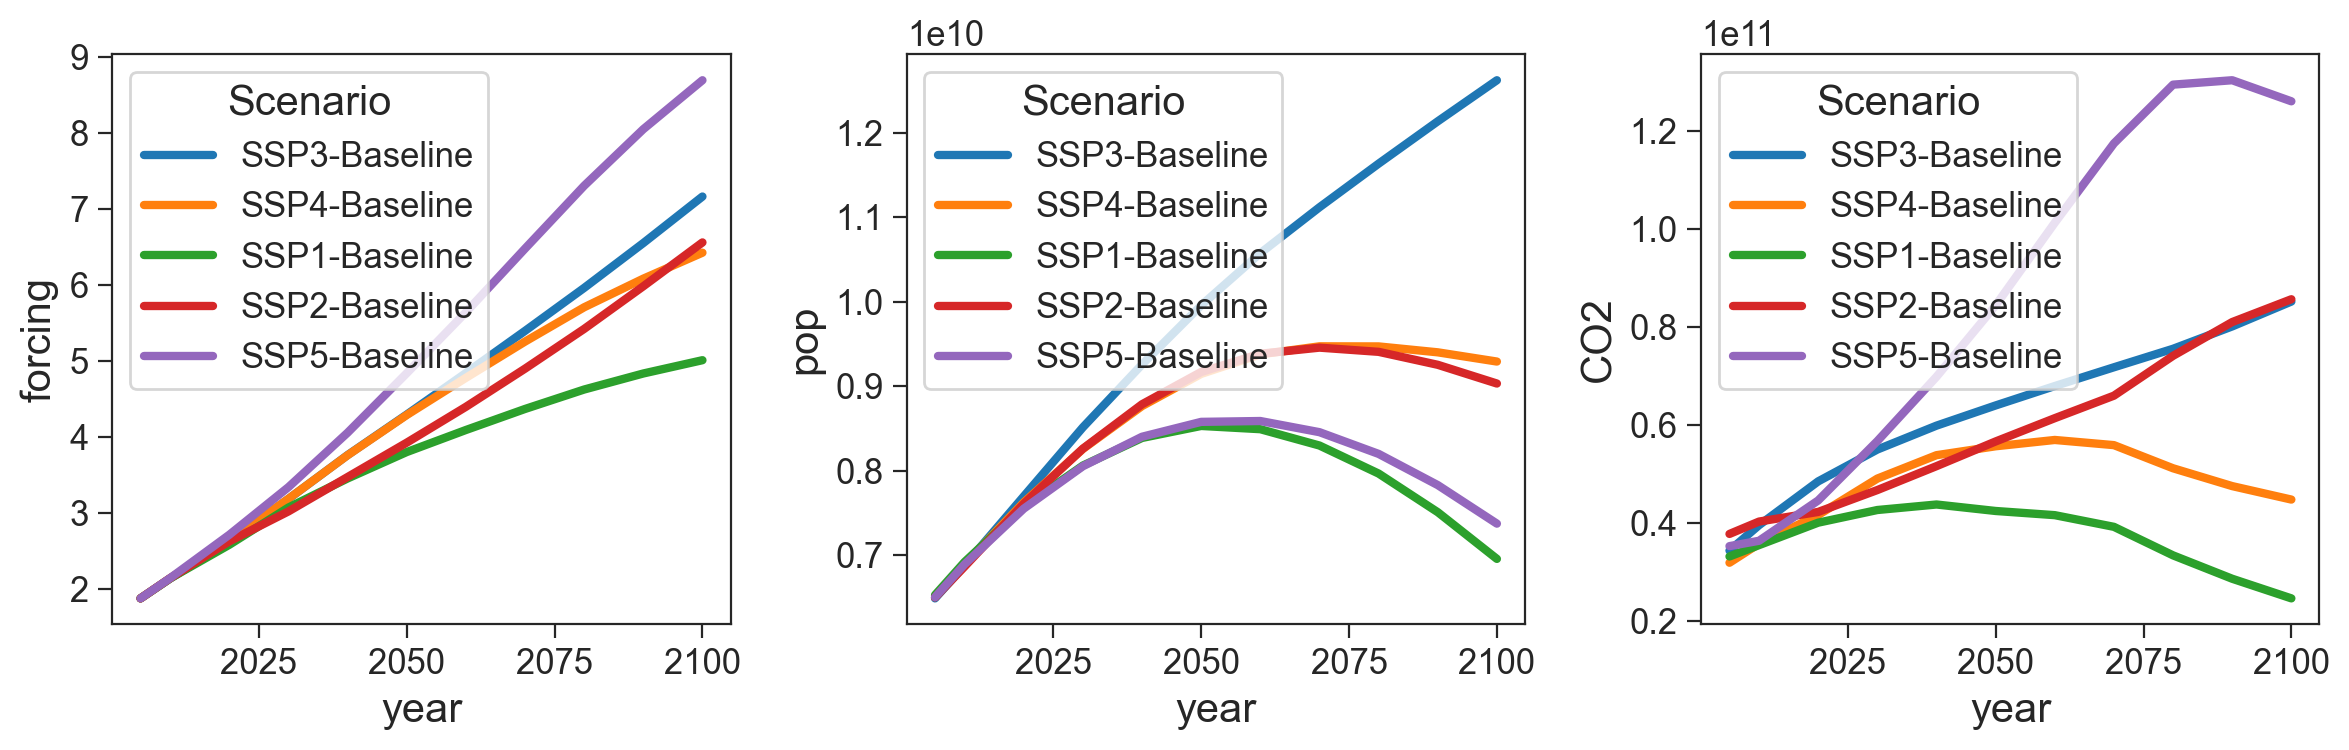

In [6]:
var_names = ['forcing','pop','CO2']
paths = ['https://osf.io/download/tkrf7/', 'https://osf.io/download/ed9aq/','https://osf.io/download/gcb79/']
axis_size=4
fig,ax=plt.subplots(1,len(var_names),figsize=(axis_size*len(var_names),axis_size))
for ax_idx,var_name in enumerate(var_names):
    path = pooch.retrieve(paths[ax_idx],known_hash=None)
    data_df=get_IPCC_data(var_name, path)
    sns.lineplot(ax=ax[ax_idx],data=data_df,x='year',y=var_name,hue='Scenario') # plot the data

In previous days, you have seen that applying greenhouse gas forcing to a climate model raises global temperature and impacts other climate effects like changes in precipitation.

The IAM projections that use these forcing profiles impose the resulting temperature change into a socioeconomic model component, to ensure the amount of emissions produced is consistent with the forcing for that scenario. There are 5 main scenarios (called *socioeconomic pathways (SSPs)*) that the IPCC considers, with each SSP represented by a distinct color in the above plots. We'll get into the details of SSPs in a subsequent tutorial. 

Not every variable in IAMs is endogenous (i.e. determined by other variables in the model). Some variables, like population or technology growth, are exogeneous. Exogeneous variables are given to the model and, in the case of population and economic growth, are derived from simple growth models. 

### **Question 1**

1. Having watched the video on the limits of growth, why might the continued growth in both population and economy not be assured?

In [1]:
# to_remove explanation
"""
1. The population growth is projected to decline and the human population is projected to stabilize towards the end of the century, as the consumption of resources continues to grow.
An economy based on growth-oriented extraction of a finite resource will collapse once it exhausts consumable resources.
""";

'\n1. The population growth is projected to decline and the human population is projected to stabilize towards the end of the century, as the consumption of resources continues to grow.\nAn economy based on growth-oriented extraction of a finite resource will collapse once it exhausts consumable resources.\n'

# **Section 2: World Models and `World3`**
In this section you will take a step back from IAMs and use another model class, *world models*, to first explore how socioeconomic system variables like population, capital and pollution co-evolve. You've already seen world models in the video for this tutorial, but let's recap what they are and why they are interesting.

World models are another modelling tradition separate from the policy optimization found in an Integrated Assessment Model. They are models of the world in which all variables are endogeneous, *i.e.* the model is self-contained and simply runs as a dynamical system if given an initial condition and equations describing rates of change of the variables. The important variables in a world model are similar to those of Integrated Assessment Models: capital, production, population, pollution etc. 

`World3` is a world model that was developed in the 1970s and doesn't have an explicit climate component (perhaps its developers were unaware of climate change at the time, as many were back then). `World3` does have a *pollution* variable that is driven by industrial activity, and this pollution negatively impacts food production and directly increases mortality rates via health effects. If we were developing `World3` today with our knowledge of human-driven climate change, we would add greenhouse gas emissions as a component of the pollution variable, which is the place in `World3` representing the damaging waste of our industrial activity.  

The reason we are looking at `World3` here in this first tutorial, is that:
1. `World3` is an instructive world model of the resource depletion and pollution problem. These problems are prior to climate change in that they encapsulate it, and understanding them helps us understand the socioeconomic forces at work in driving the emissions that are the source of the climate change problem.
2. World models provide an alternative modelling tradition not steeped in the neoclassical economics on which IAMs are based. This provides some diversity in perspective.

*Note: the model in `World3` is not only wrong (i.e. missing many variables), but is a poor idealization, i.e. not necessarily even qualitatively predictive because it is missing some determining variables/model features (e.g. technology innovation/adaptation). It is thus almost certainly not predictive, but is still useful for thinking about 'world systems' because it includes important relationships between some key natural and socio-economic variables that we will look at here and also see later when we study IAMs. In later tutorials we will also critique elements of IAMs (e.g. for lacking important variables).*

## **Section 2.1: A Complete Map of `World3`**

Welcome to World3! Here is a stock-flow diagram of the full model:

In [6]:
display(Image(url="https://osf.io/download/hzrsn/", width=1000, unconfined=True))
# copyrighted image from the textbook:
# Meadows, D.L.; Behrens, W.W.; Meadows, D.L.; Naill, R.F.; Randers, J.; Zahn, E.K.O. The Dynamics of Growth in a Finite World; Wright-Allen Press: Cambridge, MA, USA, 1974.
# Source: https://www.mdpi.com/sustainability/sustainability-07-09864/article_deploy/html/images/sustainability-07-09864-g001.png
# Alternate image from the precursor model: Jay Forrester's world dynamic model: https://petterholdotme.files.wordpress.com/2022/04/world-dynamics.png

### **Question 2.1**
1. Increase the width of this image to 3000 and scroll around to see what words you find in the node labels of the different parts of the model. Identify a category label within each quadrant of the model

In [1]:
# to_remove explanation
"""
1. upper-left example: population

upper-right example: pollution

bottom-left example: industrial output

bottom-right example: food per capita
""";

## **Section 2.2: A Sub-region of the Map of `World3`**

Here is a reduced diagram containing only some major variables and thier couplings:

In [9]:
display(Image(url="https://osf.io/download/h3mj2/", width=250))
#modified from another copyrighted image from Limits To Growth (1972, page 97). This would be easy to reproduce

This image can be used to follow a *pathway* describing the flow of model variable dependencies, to gain insight into how the model works. 

For example, one pathway described by this image is that industrial capital grows with investment and produces industrial output. This industrial outpute generates pollution and agricultural capital which, along with cultivated land, generate more food. Increasing pollution and decreasing [denoted by (-) in the image] food per capita drive up mortality, which decreases population through more deaths per year. In contrast, fertility increases population via births per year.

There is a clear and intricate web of dependencies between these various factors. Changes in one area, such as industrial investment, can have cascading effects through this system, ultimately influencing population size, health, and wellbeing. This underscores the interconnected nature of socio-economic systems and the environment.

### **Questions 2.2**
Based on the model variable dependancy pathway described above and in the image, can you describe a: 
1. *Positive* feedback loop? 
2. *Negative* feedback loop? 

In [2]:
# to_remove explanation
"""
1. Positive Feedback Loop - Larger populations could produce greater investment, particularly if a significant portion of the population is engaged in productive labor. This, in turn, would boost industrial capital, resulting in more food which can sustain a larger population.
2. Negative Feedback Loop - Pollution and Agricultural Output: High levels of pollution can degrade the quality of land and water resources needed for agriculture, leading to reduced food production. This reduced agricultural output might spur efforts to limit industrial pollution, creating a negative feedback loop.
""";


# **Section 3: Working with `pyworld3`**

In this section you will use a `python` implementation of the `World3` called `pyworld3`. This model is called is openly accessible [here](https://github.com/cvanwynsberghe/pyworld3).

We have pre-defined a plotting function that also runs `pyworld3`, that you will use in this section. The plotting function has two inputs: 
- The initial amount of non-renewable resources (`nri_factor`; default value is 1), and 
- A perturbed value of the lifetime of industrial capital to which the system will be perturbed at the perturbation year (`new_lifetime_industrial_capital`)

In addition, you need to set the end year of the simulations you wish to conduct. In this example you should stop the simulations at 2100, which is also when most IPCC Earth System Model projections end.

In [10]:
maxyear = 2100

## **Section 3.1: Original (Business-As-Usual - *BAU*) Scenario**

The Business-As-Usual (*BAU*) scenario assumes continued growth based on historical trends, alongside minimal mitigation. In this scenario there is specified amount of accessible, remaining non-renewable resources (normalized to 1 in the plots).

/srv/conda/envs/notebook/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


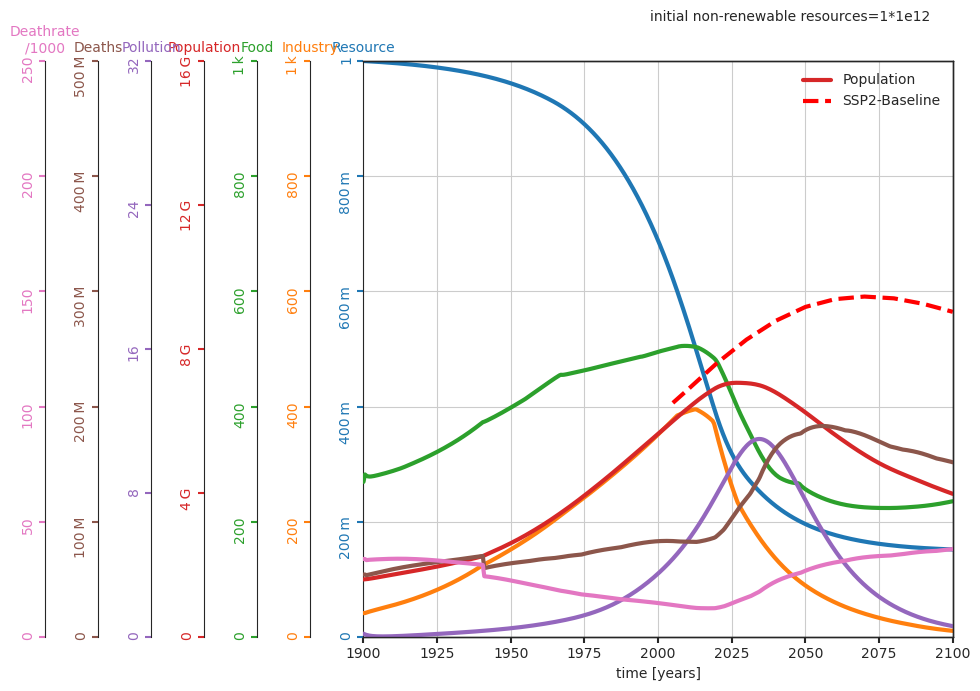

In [9]:
world3 = World3(year_max=maxyear)
run_and_plot(world3)
# plt.savefig("world3_timeseries_case_1.png",transparent=True,bbox_inches="tight",dpi=300)

Now, let's observe the dynamics of various factors: industrial output (rising orange), food per capita (rising green), and population (rising red). Initially, these factors experience growth. However, as non-renewable resources start rapidly depleting (falling blue), industrial production begins to decline (falling orange). This decline subsequently impacts food production (falling green) and medical services. This causes an increase in the death rate (rising pink) and a decline in population (falling red) during the latter half of the 21st century.

For comparison, the red dashed line represents the population projection for the IPCC baseline scenario of SSP2, which reflects a continuation of current trends (effecively their business-as-usual scenario). It is important to note the contrast between the SSP projection and the one provided by `World3`.

## **Section 3.2: *BAU3* - An Abundant Resource Scenario**

The previous scenario was resource-constrained, as the collapse in growth was driven by the limited available resources in the middle of the 21st century. In this section you will create a scenario that is not purely resource-constrained by initializing the `pyworld3` with triple the initial non-renewable resources of the *BAU* scenario. As such, let's call this new scenario *BAU3*.

### **Coding Exercise 3.1**

To create the *BAU3* scenario you will need to triple the initial resources, which could represent the effect of increased efficiency in resource extraction (e.g. crop yields, as has been observed over the last decades, or the "learning-by-doing" effect seen in the economics of many energy technologies). **Based on the input parameters of the `run_and_plot()` function discussed above, run the *BAU3* scenario and plot the output.** 

In [5]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Based on the input parameters of the `run_and_plot()` function discussed above, run the BAU3 scenario and plot the output.")
#################################################

run_and_plot(world3, nri_factor=3)
# plt.savefig("world3_timeseries_case_2.png",transparent=True,bbox_inches="tight",dpi=300)

NotImplementedError: Student exercise: Based on the input parameters of the `run_and_plot()` function discussed above, run the BAU3 scenario and plot the output.

/srv/conda/envs/notebook/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


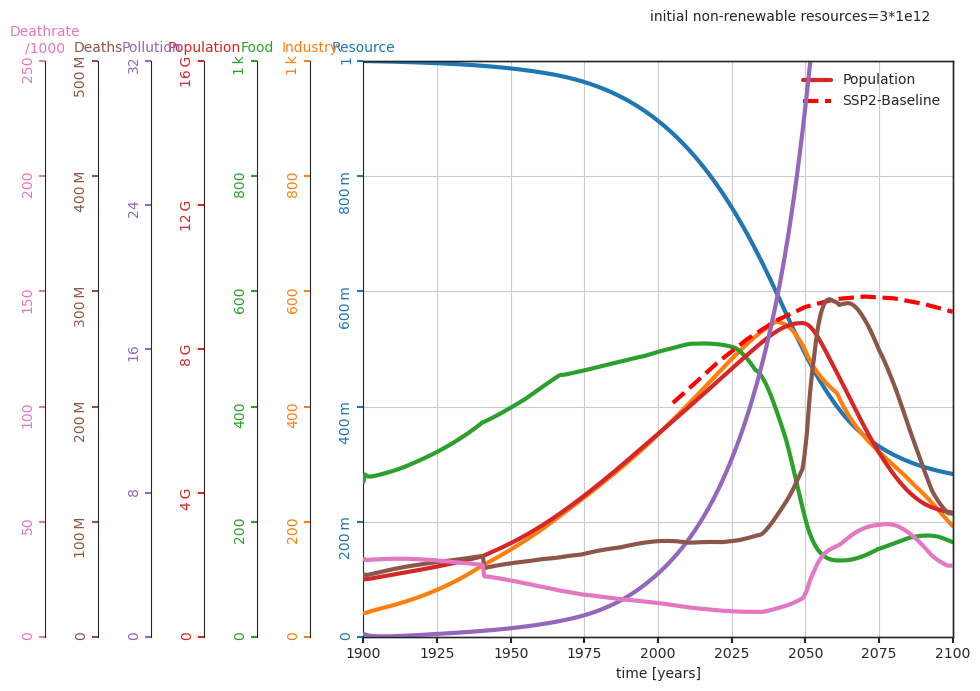

In [10]:
# to_remove solution

run_and_plot(world3, nri_factor=3)
# plt.savefig("world3_timeseries_case_2.png",transparent=True,bbox_inches="tight",dpi=300)

Notice that the decline in industrial output still occurs in this scenario, but it is delayed by a few decades due to the larger resource pool. However, unlike the previous case, the extended period of exponential industrial growth leads to a significant increase in pollution (purple). As a result, the population crash, which is now driven by both increased pollution and diminishing resources, is faster and more substantial than the *BAU* scenario's population crash.

## **Section 3.3: *BAU3* with an Active Cap on Production**

### **Coding Exercises 3.3**

Turn down production abruptly via a step decrease in the lifetime of industrial capital, by imposing a reduction from 14 to 8 years in 2025.

*Note: for further details of IAM transitioning with reductions in lifetime capital see [Rozenberg et al. *Environ. Res. Lett.* (2015)](https://iopscience.iop.org/article/10.1088/1748-9326/10/9/095006/pdf).*

/srv/conda/envs/notebook/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


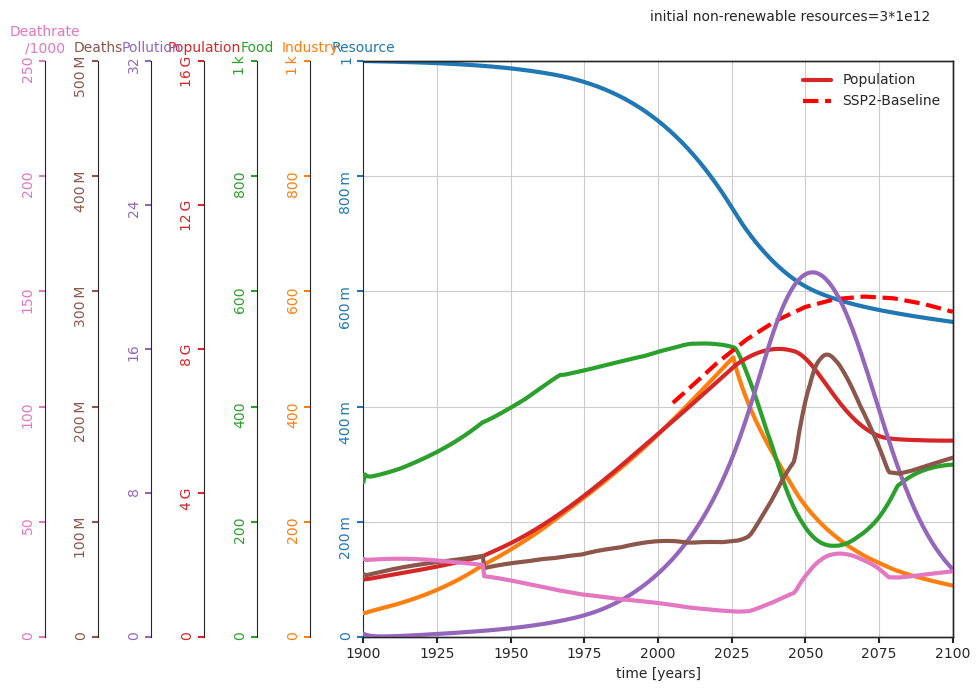

In [11]:
world3 = World3(pyear=2025, year_max=2100)
run_and_plot(world3, nri_factor=3, new_lifetime_industrial_capital=8)
# plt.savefig("world3_timeseries_case_3.png",transparent=True,bbox_inches="tight",dpi=300)

Notice that by reducing production, pollution levels are also reduced, which in turn limits the decline in population to a plateau. This approach preserves a significant amount of non-renewable resources, such as ecosystems. However, over time, the asymptotic death rate gradually increases, approaching that of the second scenario. As a result, the population plateau is not sustained, and the population continues to decline slowly beyond the year 2100.

Dropping industrial output negatively impacts our ability to develop new technologies, e.g. those needed for decarbonization (c.f. the article [Decarbonizing the downturn: Addressing climate change in an age of stagnation* by Copley, 2022](https://journals.sagepub.com/doi/full/10.1177/10245294221120986). This stagnation scenario is a central challenge faced in the narrative of Shared Socio-economic Pathway 3 (SSP3 *Regional Rivary*).

### **Questions 3.3:**
1. What scenarios might lead to a drop in the lifetime of industrial capital?
2. What are some important features of the world, society, and/or economy that are missing in this model?

In [ ]:
# to_remove explanation

"""
1. Some examples are environmental degradation, economic instability (e.g., recessions and downturns), and conflicts or disasters (e.g., war and natural disasters)
2. Important features that are missing: e.g., technological innovation; government policies & regulations; education and health services, etc.). Some additional model limitations are listed in the next cell.
"""

**Some additional model limitations:**
- No spatial structure: spatial structure is important, as it allows for distinct regional solutions that aid or hinder global cooperation (c.f. emergence of cooperation in game theory).
- Ignores technology innovation, including innovations in adaptation and mitigation
- There is an *ad hoc* relationship between economic growth, investment in health services, and changes in life expectancy
- It only includes a monolithic non-renewable resource (e.g. doesn't break down the resource into renewable & non-renewable classes)
- ...probably lots more!


# **Bonus Section: Validating `pyworld3`**

For reference, here are the validity analyses presented in the `pyworld3` github repository. These are standard parameter runs of the model overlaid with those of the original implementation to show validity of the `pyworld3` package implementation

In [12]:
world3 = World3()
# nonrenewable resources initial [resource units]
world3.init_world3_constants()
world3.init_world3_variables()
world3.set_world3_table_functions()
world3.set_world3_delay_functions()
world3.run_world3(fast=False)

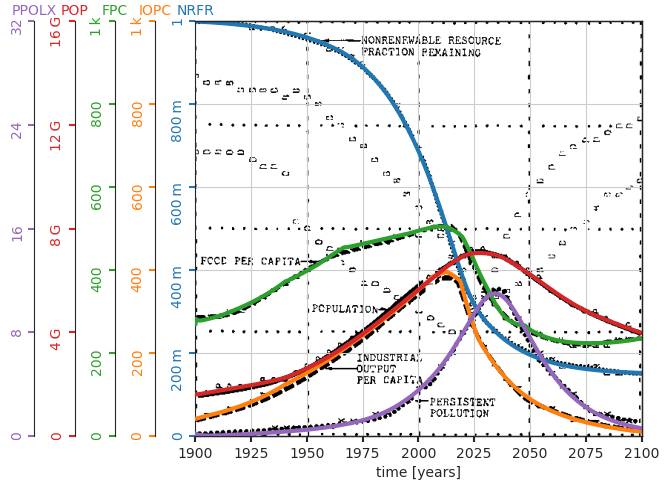

In [13]:
plot_world_variables(world3.time,
                     [world3.nrfr, world3.iopc, world3.fpc, world3.pop,
                      world3.ppolx],
                     ["NRFR", "IOPC", "FPC", "POP", "PPOLX"],
                     [[0, 1], [0, 1e3], [0, 1e3], [0, 16e9], [0, 32]],
                     img_background=pooch.retrieve("https://osf.io/download/r4npd/",known_hash=None),
                     figsize=(7, 5),
                     title=None,
                     grid=True)

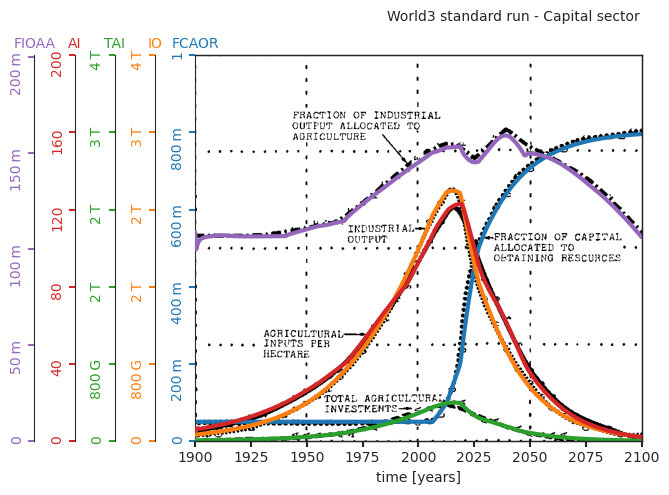

In [14]:
plot_world_variables(world3.time,
                     [world3.fcaor, world3.io, world3.tai, world3.aiph,
                      world3.fioaa],
                     ["FCAOR", "IO", "TAI", "AI", "FIOAA"],
                     [[0, 1], [0, 4e12], [0, 4e12], [0, 2e2], [0, 0.201]],
                     img_background=pooch.retrieve("https://osf.io/download/d6gz2/",known_hash=None),
                     figsize=(7, 5),
                     title="World3 standard run - Capital sector")

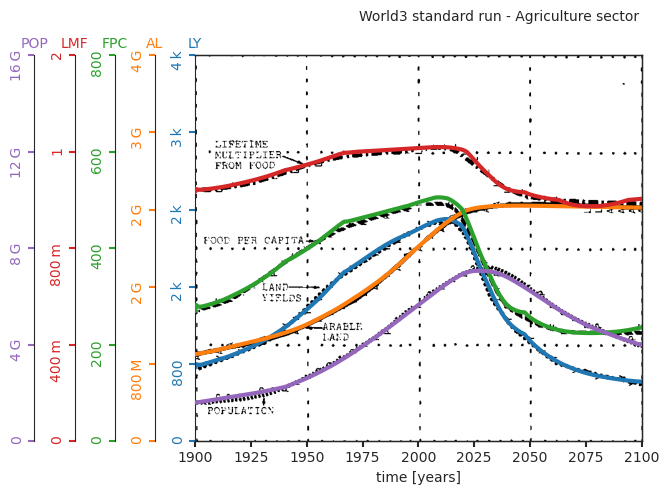

In [15]:
plot_world_variables(world3.time,
                     [world3.ly, world3.al, world3.fpc, world3.lmf,
                      world3.pop],
                     ["LY", "AL", "FPC", "LMF", "POP"],
                     [[0, 4e3], [0, 4e9], [0, 8e2], [0, 1.6], [0, 16e9]],
                    img_background=pooch.retrieve("https://osf.io/download/t2qdm/",known_hash=None),
                     figsize=(7, 5),
                     title="World3 standard run - Agriculture sector")

# **Summary**
In this tutorial, you explored the interplay between climate and socio-economic models, which form the bedrock for the IAMs used in IPCC projections. 

You examined this interplay through a `World3`, a *World model* which is a class of model similar to IAMs. You followed several variable dependency pathways within this model to identify some positive and negative feedback loops, and then you used this model to simulate 3 future scenarios which varied in their amount ofinitially available non-renewable resources and the lifetime of capital. Through these simulations you explored the factors driving current population growth, and its future projected decline or stabilization. In particular, you found rapid resource consumption can have negative impacts by exhausting these resources and/or by increasing pollution and reducing human health, highlighting the potential threats of unregulated resource extraction on a finite planet.

Finally, you learned about some of the limitations of models like `World3`, as they don't include some important natural and socio-economic variables. By exploring these complex concepts, you are now better equipped to engage with discussions on climate change, resource management, and sustainable economic growth.

# **Resources**

The data for this tutorial can be accessed here NEED TO ADD LINKS FOR ALL DATA USED